In [2]:
%matplotlib inline
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from imaka.analysis import moffat
from astropy.table import Table
from astropy.modeling import fitting
from astropy.stats import sigma_clip
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


/anaconda/lib/python3.6/site-packages/astropy/config/configuration.py:541: ConfigurationMissingWarning: Configuration defaults will be used due to FileExistsError:17 on None
  warn(ConfigurationMissingWarning(msg))


# PSF Variability over Field of View

This preliminary analysis of PSF variability over the field of view shows no correlation between position on the field and either PSF size or elongation.  The plots below were generated from a stack of images from 20170518, with each data point representing one star in the stacked image.  For the scatter plots (the lower two of each set of four), the data are restricted to showing points within two standard deviations of the average.  The first set of four plots are open loop, and the second four are closed.

In [3]:
stack_dir = "/Users/fatima/data/imaka/RUN5/20170521/FLI/reduce/stacks/"
starlist = stack_dir + "FLD2_stack_closed_stars.txt"
image = stack_dir + "FLD2_stack_closed.fits"

img, hdr = fits.getdata(image, header=True)
stars = Table.read(starlist, format='ascii')
N_stars = len(stars)

x_cents = []
y_cents = []
mags  = []
FWHMs   = []

stars[0]
for star in stars:
    if star['flux'] > 5 and star['peak'] < 20000 and \
    star['ycentroid']-10 > 0 and star['xcentroid']-10 > 0 and \
    star['ycentroid']+10<np.shape(img)[0] and star['xcentroid']+10<np.shape(img)[1]:
        x_cents.append(star['xcentroid'])
        y_cents.append(star['ycentroid'])
        mags.append(-2.5 * np.log10(star['flux']))
        
for i in range(len(x_cents)):
    one_star = img[int(y_cents[i])-10 : int(y_cents[i])+10+1, int(x_cents[i])-10 : int(x_cents[i])+10+1]
    y, x = np.mgrid[:21, :21]
    z = one_star
    m_init = moffat.Elliptical_Moffat2D(N_sky = 0, amplitude=np.amax(z),  x_0=10.5, y_0=10.5, width_x = 4.55, width_y=4.17)
    fit_m = fitting.LevMarLSQFitter()
    m = fit_m(m_init, x, y, z)
    if abs(m.width_x.value) < abs(m.width_y.value):
        FWHM = 2*abs(m.width_x.value)*np.sqrt((2**(1/m.power.value))-1)*0.08
    else:
        FWHM = 2*abs(m.width_y.value)*np.sqrt((2**(1/m.power.value))-1)*0.08
    FWHMs.append(FWHM)

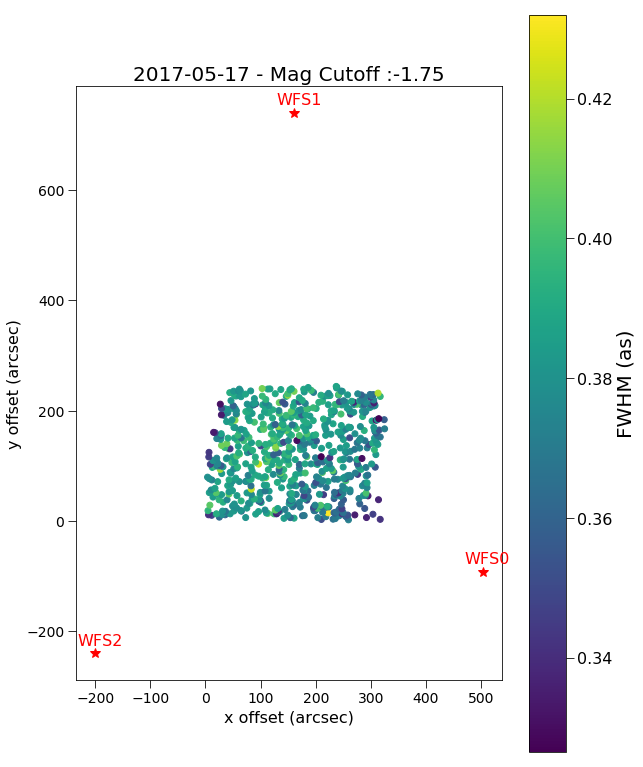

In [4]:
#WFS POSITIONS CALCULATED BY HAND IN DS9
scale = np.mean([184/3066, 242/4088])
WFS_x = np.array([273, -139, -6, 48])*0.08/scale
WFS_y = np.array([145, 316, -327, 62]) *0.08/scale

WFS_x = np.array([375*0.08/scale, 120*0.08/scale, -200])
WFS_y = np.array([-69*0.08/scale, 551*0.08/scale, -240])

###
filt = sigma_clip(FWHMs, sigma=3, iters=5, copy=False)

x = np.ma.array(FWHMs, mask=filt.mask)
FWHMs_clip = x[~x.mask].data

x = np.ma.array(x_cents, mask=filt.mask)
xcents_clip = x[~x.mask].data

x = np.ma.array(y_cents, mask=filt.mask)
ycents_clip = x[~x.mask].data


plt.figure(1, figsize=(9,11))
plt.scatter(np.array(xcents_clip)*0.08, np.array(ycents_clip)*0.08, c=np.array(FWHMs_clip))#, alpha=0.75)#, vmin=np.mean(FWHMs)-np.std(FWHMs), vmax=np.mean(FWHMs)+np.std(FWHMs))
plt.plot(WFS_x, WFS_y, 'r*', markersize=10)
plt.xlabel('x offset (arcsec)', fontsize=16); plt.ylabel('y offset (arcsec)', fontsize=16); plt.title("2017-05-17 - Mag Cutoff :"+str(np.round(np.max(mags),2)), fontsize=20)
plt.colorbar(label='FWHM (as)'); plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.gca().set_aspect('equal', adjustable='box')
for i in range(3):
    plt.text(WFS_x[i]-33, WFS_y[i]+15, 'WFS'+str(i), color='red', fontsize=16)


plt.tight_layout()
#plt.savefig("/Users/fatimaabdurrahman/Desktop/Var.png")


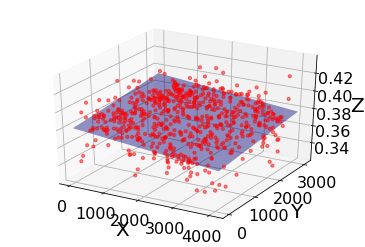

In [5]:
# some 3-dim points
data = np.array([xcents_clip, ycents_clip, FWHMs_clip]).transpose()

# regular grid covering the domain of the data
X,Y = np.meshgrid(np.arange(0, 4088, 10), np.arange(0,3066, 10))
XX = X.flatten()
YY = Y.flatten()

order = 1    # 1: linear, 2: quadratic
if order == 1:
    # best-fit linear plane
    A = np.c_[data[:,0], data[:,1], np.ones(data.shape[0])]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])    # coefficients
    
    # evaluate it on grid
    Z = C[0]*X + C[1]*Y + C[2]
    
# plot points and fitted surface
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,2], c='r', alpha=0.5, s=10)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.5, color='b')
plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('Z')
ax.axis('equal')
ax.axis('tight')
plt.show()

FWHM_plane = xcents_clip * C[0] + ycents_clip * C[1] + C[2]

In [6]:
mean = np.mean((FWHMs_clip-FWHM_plane+np.mean(FWHMs_clip)))
per = abs(((FWHMs_clip-FWHM_plane+np.mean(FWHMs_clip)) - mean)/mean)
diff = np.mean(per)
minv = 0.29; maxv = .44
ind=np.where(FWHMs_clip < 0.58)
np.max(FWHMs_clip)

0.4320132060582928

/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


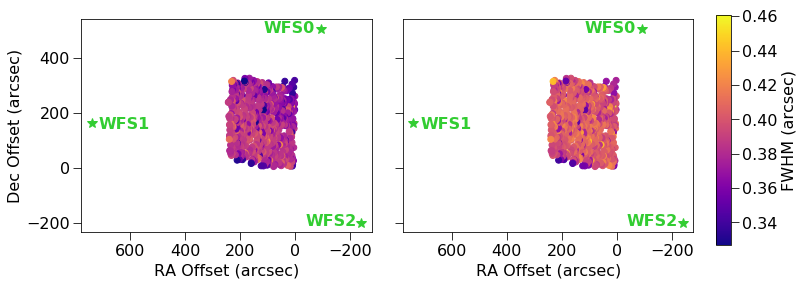

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,4))


dat1 = FWHMs_clip[ind]
dat2 = np.array(FWHMs_clip)[ind]-FWHM_plane[ind]
dat3 = dat2 + .40#(np.min(dat1)-np.min(dat2))

x = np.array(ycents_clip)[ind]*0.08
y =np.array(xcents_clip)[ind]*0.08

minv = np.min(np.concatenate([dat1, dat3]))
maxv = np.max(np.concatenate([dat1, dat3]))

ax1.scatter(x,y,  c=dat1, cmap=cm.plasma, vmin=minv, vmax=maxv)
ax1.plot(WFS_y , WFS_x, '*', color='limegreen', markersize=10)
ax1.text(WFS_y[0]+20+190, WFS_x[0]-15, 'WFS'+str(0), color='limegreen', fontsize=16, fontweight='bold')
ax1.text(WFS_y[1]-195+170, WFS_x[1]-20, 'WFS'+str(1), color='limegreen', fontsize=16, fontweight='bold')
ax1.text( WFS_y[2]+15+190, WFS_x[2]-10,'WFS'+str(2), color='limegreen', fontsize=16, fontweight='bold')
ax1.axis('equal')#, adjustable='box')
ax1.set_xlabel('RA Offset (arcsec)', fontsize=16)
ax1.set_ylabel('Dec Offset (arcsec)', fontsize=16)
ax1.invert_xaxis()

im = ax2.scatter(x,y, c=dat3,  cmap=cm.plasma,vmin=minv, vmax=maxv)
ax2.plot(WFS_y , WFS_x, '*', color='limegreen', markersize=10)
ax2.text(WFS_y[0]+20+190, WFS_x[0]-15, 'WFS'+str(0), color='limegreen', fontsize=16, fontweight='bold')
ax2.text(WFS_y[1]-195+170, WFS_x[1]-20, 'WFS'+str(1), color='limegreen', fontsize=16, fontweight='bold')
ax2.text( WFS_y[2]+15+190, WFS_x[2]-10,'WFS'+str(2), color='limegreen', fontsize=16, fontweight='bold')
ax2.axis('equal', adjustable='box');
ax2.set_xlabel('RA Offset (arcsec)', fontsize=16)
ax2.invert_xaxis()

cbaxes = f.add_axes([1, 0.15, .02, .8]) 
cb = f.colorbar(im, ax=[ax1, ax2], cax=cbaxes)
cb.set_label(label='FWHM (arcsec)',size=16)

f.subplots_adjust(wspace=0.05)
f.tight_layout()
f.savefig("varplot.png", bbox_inches="tight")